In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
print(os.listdir('/content/drive/MyDrive/Alzh/train'))

Mounted at /content/drive
['MildDemented', 'NonDemented', 'ModerateDemented', 'VeryMildDemented', 'Labels.npy', 'Cells.npy']


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils import shuffle

import ipywidgets as widgets
import io
from PIL import Image
import tqdm
from IPython.display import display,clear_output

In [ ]:
%config Completer.use_jedi = False

In [ ]:
def image(direction):
    list_dir = os.listdir(direction)
    plt.figure(figsize=(21,15))
    for i in range(1,10):
        plt.subplot(7,3,i)
        img= plt.imread(os.path.join(direction,list_dir[i]))
        plt.imshow(img,cmap='gray')
        plt.axis('off')
        plt.title(direction)
    plt.tight_layout()

In [ ]:
non_train = '/content/drive/MyDrive/Alzh/train/NonDemented'
very_mild_train = '/content/drive/MyDrive/Alzh/train/VeryMildDemented/' 
mild_train = '/content/drive/MyDrive/Alzh/train/MildDemented/'
moderate_train = '/content/drive/MyDrive/Alzh/train/ModerateDemented/'
non_test = '/content/drive/MyDrive/Alzh/test/NonDemented/'
very_mild_test = '/content/drive/MyDrive/Alzh/test/VeryMildDemented/' 
mild_test = '/content/drive/MyDrive/Alzh/test/MildDemented/'
moderate_test = '/content/drive/MyDrive/Alzh/test/ModerateDemented/'

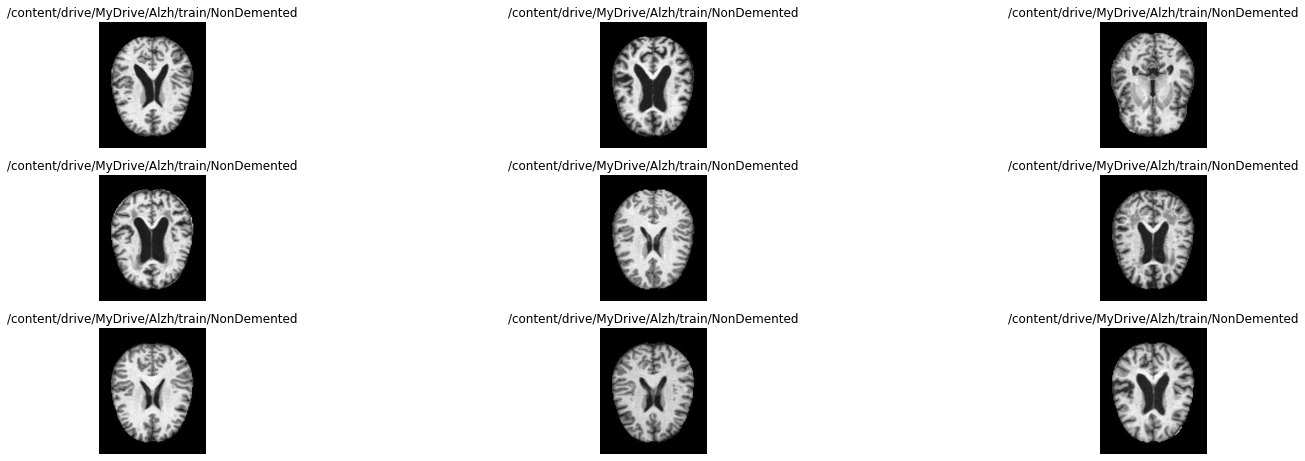

In [ ]:
image(non_train)

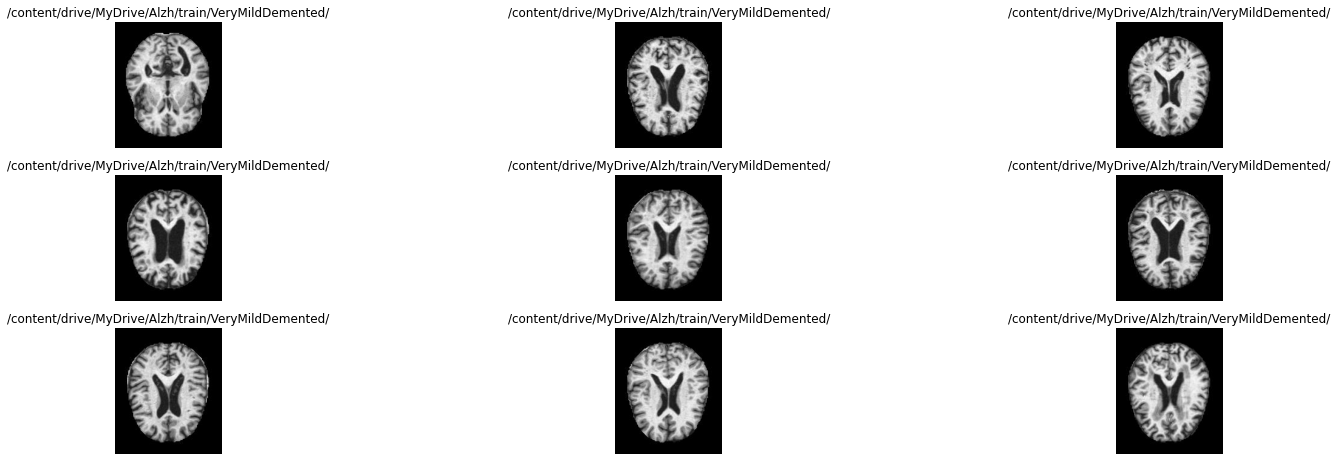

In [ ]:
image(very_mild_train)

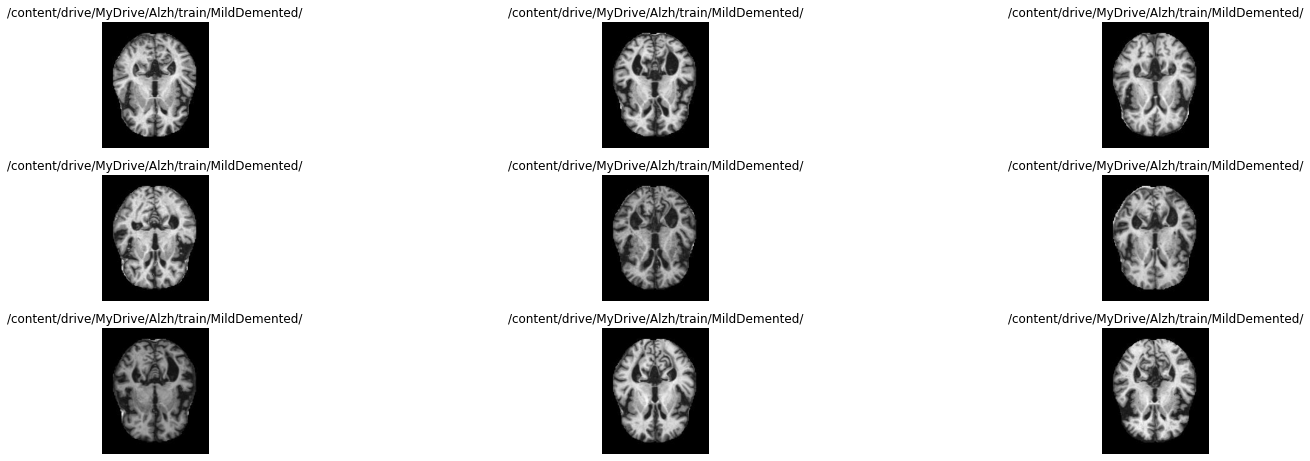

In [ ]:
image(mild_train)

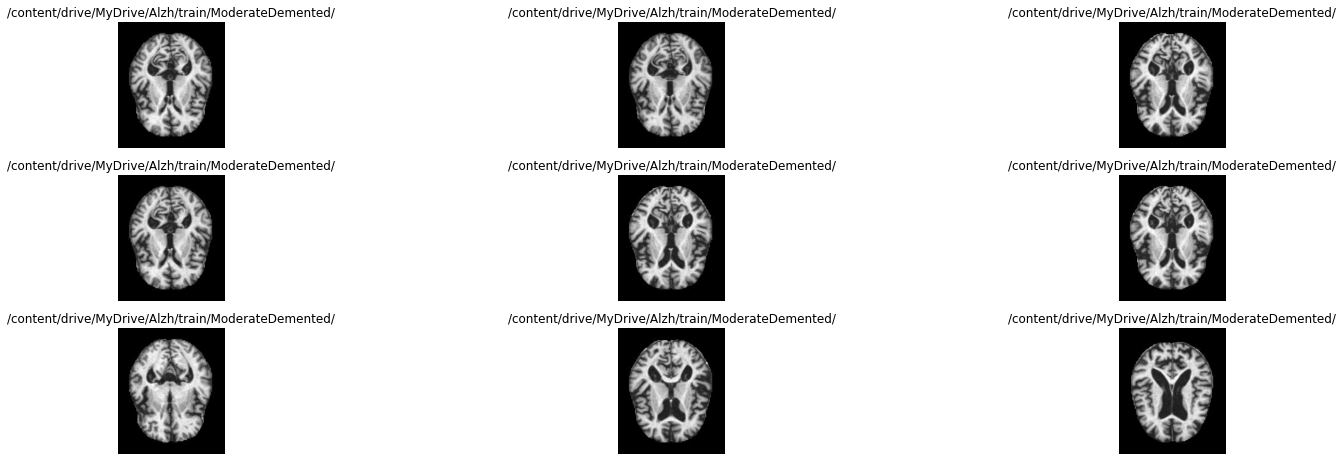

In [ ]:
image(moderate_train)

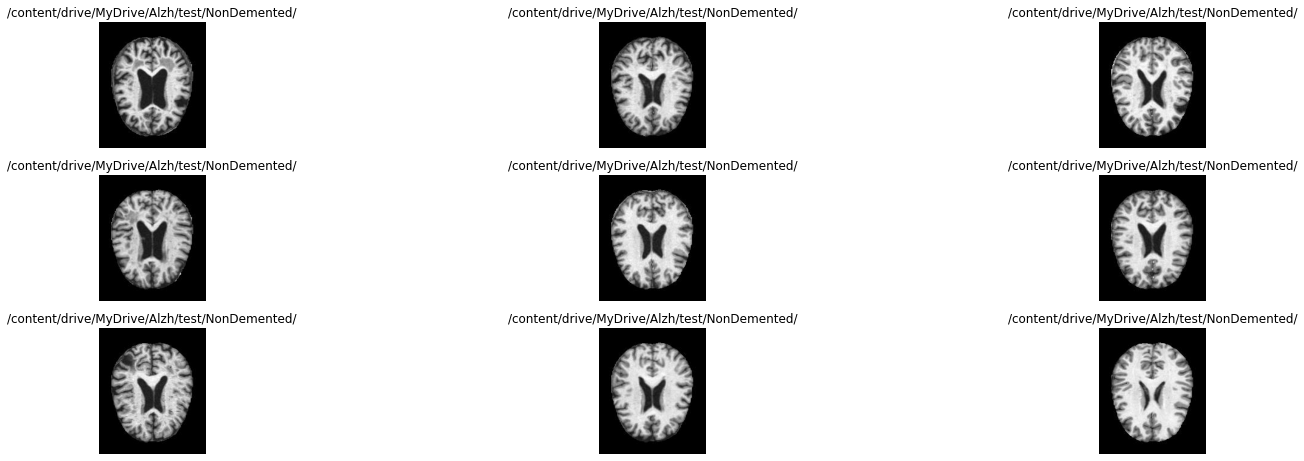

In [ ]:
image(non_test)

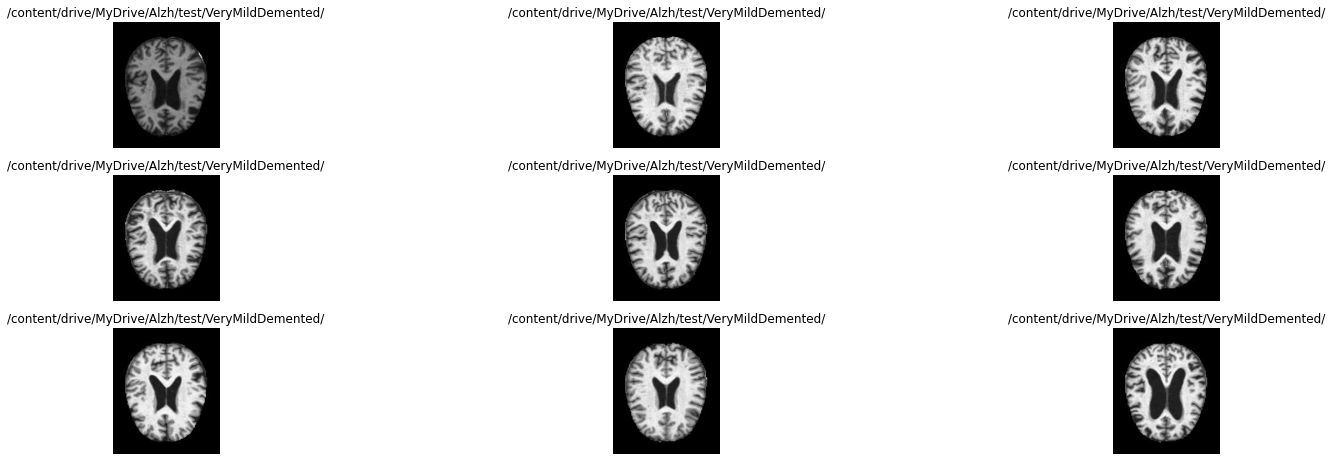

In [ ]:
image(very_mild_test)

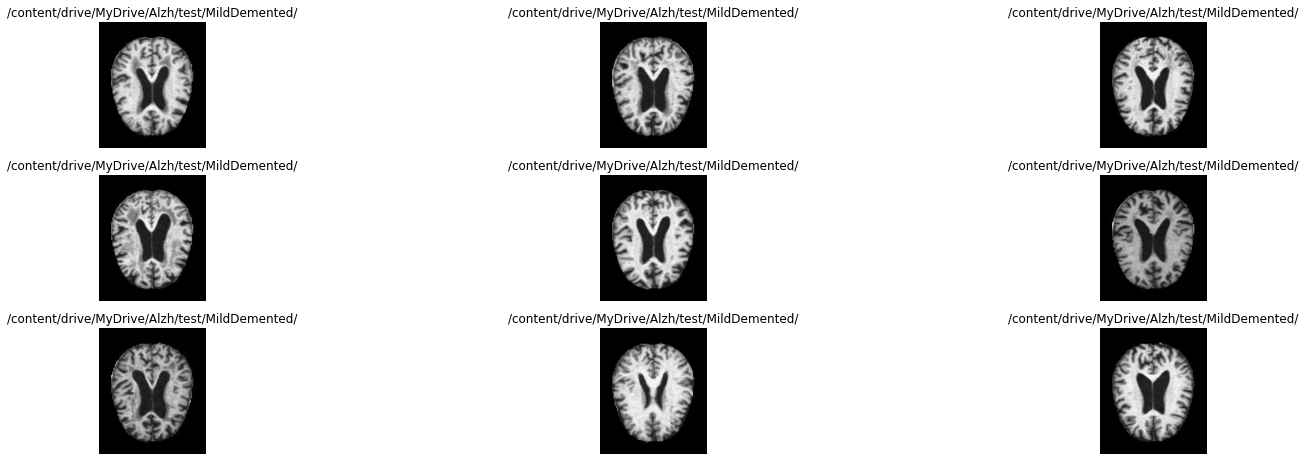

In [ ]:
image(mild_test)

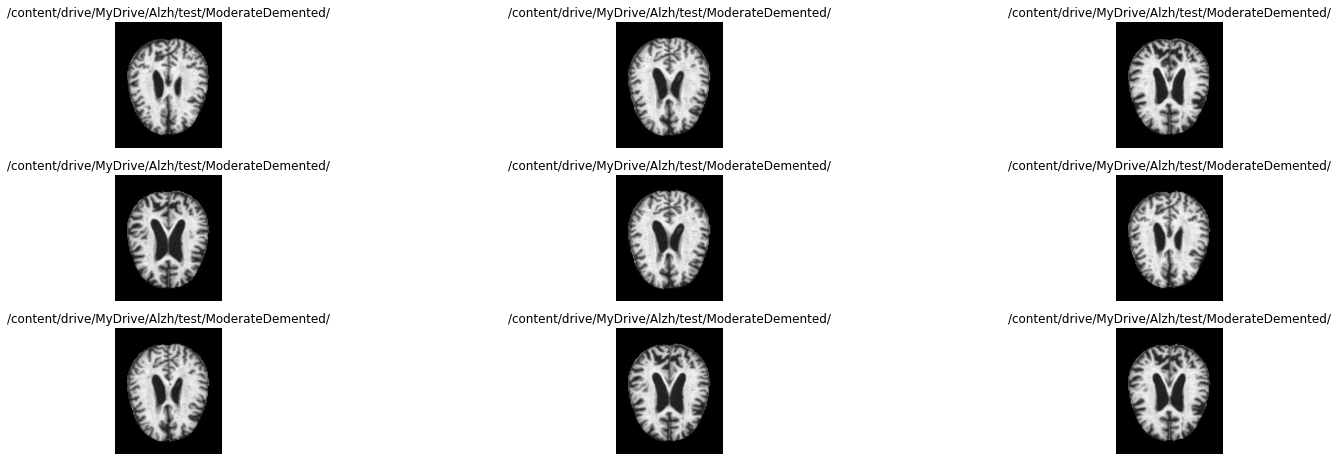

In [ ]:
image(moderate_test)

In [ ]:
BASE_DIR = '/content/drive/MyDrive/Alzh/'
TRAIN_DIR = BASE_DIR + 'train'
TEST_DIR = BASE_DIR + 'test'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 150
IMAGE_SIZE = [150, 150]
DIM = (IMG_SIZE, IMG_SIZE)

In [ ]:
train =tf.keras.preprocessing.image_dataset_from_directory(TRAIN_DIR,validation_split=.2,subset='training', seed=1337,image_size=IMAGE_SIZE,batch_size=64)

validatioin =tf.keras.preprocessing.image_dataset_from_directory(TRAIN_DIR,validation_split=.2,subset='validation', seed=1337,image_size=IMAGE_SIZE,batch_size=64)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


In [ ]:
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
num_classes=len(class_names)
train.class_names=class_names
validatioin.class_names=class_names

In [ ]:
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
num_classes=len(class_names)
train.class_names=class_names
validatioin.class_names=class_names

In [ ]:
from tensorflow.data.experimental import AUTOTUNE
def one_hot_label(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

train=train.map(one_hot_label, num_parallel_calls=AUTOTUNE)
validatioin=validatioin.map(one_hot_label, num_parallel_calls=AUTOTUNE)

In [ ]:
train= train.cache().prefetch(buffer_size=AUTOTUNE)
validatioin = validatioin.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    return block

In [ ]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [ ]:
#Conv2D layer with 16 filters and 3x3
#MaxPool2D layer will then use 32 pooling operations 
#conv_block() block with 32 filters followed by 64 filters and 128 filters
# 3 : The number of channels in the input image.
# 16 : The number of filters in each convolutional layer (in this case, three).
# 'relu' : Activation function for the convolutional layers.
# padding='same': Padding scheme used for all convolutional and dense layers.

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(4, activation='softmax')
    ])
    
    return model
# model.summary()

In [ ]:
model = build_model()
METRICS = [tf.keras.metrics.AUC(name='auc')]
model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    ) 

In [ ]:
history = model.fit(train,validation_data=validatioin,callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],epochs=10)

Epoch 1/10
65/65 [==============================] - 618s 9s/step - loss: 1.1734 - auc: 0.7688 - val_loss: 4.5928 - val_auc: 0.5145 - lr: 0.0100
Epoch 2/10
65/65 [==============================] - 258s 4s/step - loss: 0.9212 - auc: 0.8368 - val_loss: 9.7081 - val_auc: 0.6634 - lr: 0.0089
Epoch 3/10
65/65 [==============================] - 263s 4s/step - loss: 0.8952 - auc: 0.8434 - val_loss: 9.3357 - val_auc: 0.6694 - lr: 0.0079
Epoch 4/10
65/65 [==============================] - 254s 4s/step - loss: 0.8768 - auc: 0.8500 - val_loss: 6.1148 - val_auc: 0.6988 - lr: 0.0071
Epoch 5/10
65/65 [==============================] - 280s 4s/step - loss: 0.8634 - auc: 0.8563 - val_loss: 2.5745 - val_auc: 0.7733 - lr: 0.0063
Epoch 6/10
65/65 [==============================] - 256s 4s/step - loss: 0.8481 - auc: 0.8610 - val_loss: 1.0587 - val_auc: 0.7686 - lr: 0.0056
Epoch 7/10
65/65 [==============================] - 257s 4s/step - loss: 0.8306 - auc: 0.8669 - val_loss: 0.8679 - val_auc: 0.8534 - lr:

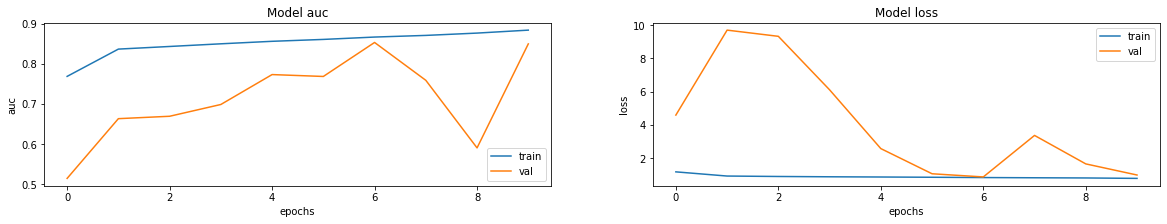

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(['auc','loss']):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history['val_' + metric])
    ax[i].set_title('Model {}'.format(metric))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(['train', 'val'])

In [ ]:
# #confusion matrix
# #Fashion MNIST
# y_pred = model.predict(validatioin)
# y_pred = np.argmax(y_pred, axis=1)
# y_pred = y_pred[:16]


# # validatioin_labels = np.array([y.numpy() for x, y in validatioin])
# # y_true = np.argmax(validatioin, axis=1)
# # y_true = validatioin
# # y_true=validatioin.map(lambda x, y: y)
# # y_true = validatioin_labels[:len(y_pred)]

# def extract_label(x, y):
#   return y
# y_true = np.array([i.numpy() for i in validatioin.map(lambda x, y: y)])
# y_pred = np.ravel(y_pred)
# y_true = np.argmax(y_true)
# # y_true = y_true[:, 0, 0]
# y_true = np.reshape(y_true, (-1,))


# print("Number of samples in y_true:", y_true.shape[0])
# print("Number of samples in y_pred:", y_pred.shape[0])
# # limit y_pred and y_true to have the same number of samples
# num_samples = 16
# y_pred_limited = y_pred[:num_samples]
# y_true_limited = y_true[:num_samples]
# # y_true_limited = np.array(y_true_limited).reshape(16,)
# y_true_limited = np.argmax(y_true_limited[:,0,:], axis=1)
# y_true_limited = y_true.reshape(-1)



# print("Shape of y_pred:", y_pred.shape)
# print("Shape of y_true:", y_true.shape)

# # Confusion matrix
# cm = confusion_matrix(y_true_limited, y_pred_limited)

# plt.figure(figsize=(12, 12))
# sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='d', cmap=plt.cm.Blues)
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.title('Confusion matrix')
# plt.show()

# # Classification report
# print(classification_report(y_true_limited, y_pred_limited, target_names=class_names))

# # y_true = validatioin.map(extract_label).numpy()

# # cm = confusion_matrix(y_true, y_pred)

# # cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# # fig, ax = plt.subplots(figsize=(15, 15))
# # sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names, ax=ax)
# # plt.ylabel('Actual')
# # plt.xlabel('Predicted')
# # plt.show()

# # cm = confusion_matrix(y_true, y_pred)

# # plt.figure(figsize=(12, 12))
# # sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='d', cmap=plt.cm.Blues)
# # plt.ylabel('Actual')
# # plt.xlabel('Predicted')
# # plt.title('Confusion matrix')
# # plt.show()

# # #classification report

# # print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, classification_report

# y_pred = model.predict(validatioin)
# y_true = np.argmax(y_true, axis=1)
# y_true = np.reshape(y_true, (16,))


# y_true = np.array([i.numpy() for i in validatioin.map(lambda x, y: y)])
# y_true = np.argmax(y_true, axis=1)

# num_samples = 16
# y_pred_limited = y_pred[:num_samples]
# y_true_limited = y_true[:num_samples]

# print("Shape of y_pred:", y_pred.shape)
# print("Shape of y_true:", y_true.shape)
# # Confusion matrix
# cm = confusion_matrix(y_true_limited, y_pred_limited)

# plt.figure(figsize=(12, 12))
# sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='d', cmap=plt.cm.Blues)
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.title('Confusion matrix')
# plt.show()

# # Classification report
# print(classification_report(y_true_limited, y_pred_limited, target_names=class_names))


16/16 [==============================] - 17s 1s/step


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


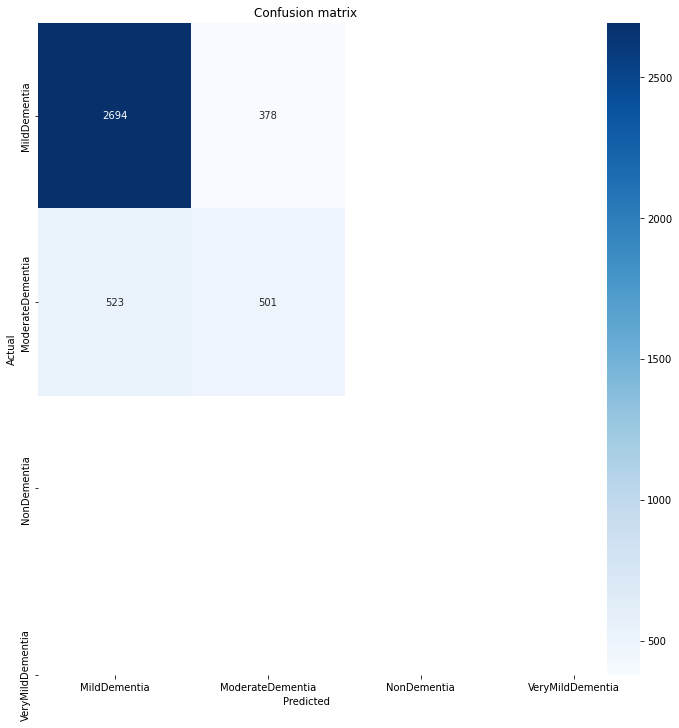

              precision    recall  f1-score   support

         0.0       0.84      0.88      0.86      3072
         1.0       0.57      0.49      0.53      1024

    accuracy                           0.78      4096
   macro avg       0.70      0.68      0.69      4096
weighted avg       0.77      0.78      0.77      4096



In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(validatioin)
y_true = np.array([i.numpy() for i in validatioin.map(lambda x, y: y)])

# Convert the predictions to binary class labels
y_pred = np.round(y_pred)

# Flatten y_true and y_pred
y_true = y_true.flatten()
y_pred = y_pred.flatten()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(cm, xticklabels=class_names, yticklabels=class_names, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix')
plt.show()

# Classification report
# print(classification_report(y_true, y_pred, target_names=class_names))
print(classification_report(y_true, y_pred))


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Alzh/test",
    image_size=IMAGE_SIZE,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1279 files belonging to 4 classes.


In [ ]:
pred = model.predict(test_ds)

40/40 [==============================] - 21s 511ms/step


In [ ]:
ev = model.evaluate(test_ds)

40/40 [==============================] - 19s 486ms/step - loss: 1.2525 - auc: 0.8172


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Alzh/test",
    image_size=IMAGE_SIZE,
)

Found 1279 files belonging to 4 classes.


In [ ]:
test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

pred = model.predict(test_ds)

ev = model.evaluate(test_ds)

40/40 [==============================] - 19s 469ms/step - loss: 1.2525 - auc: 0.8172


In [ ]:
# from sklearn.metrics import confusion_matrix
# y_true = [2, 0, 2, 2, 0, 1]
# y_pred = [0, 0, 2, 2, 0, 2]


In [ ]:
# It seems that in this script, the dataset is loaded and processed using the tf.keras.preprocessing.image_dataset_from_directory method, then the model is trained and evaluated on this dataset, but I can't see any line of code that creates the confusion matrix or the classification report.

# You'll need to add some code to create the confusion matrix and the classification report, you can use the confusion_matrix and classification_report from sklearn.metrics library. Here is an example of how you can use it:

# Copy code
# # predict the classes for the test images
# y_pred = model.predict_classes(X_test)

# # create a confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred)

# # create a classification report
# class_report = classification_report(y_test, y_pred, target_names=class_names)